In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2


In [2]:

from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from matplotlib.patches import Circle
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
from matplotlib.colors import LogNorm

In [5]:
path = "/data/OWN/Mochima/SF0/Stable/output_00041"
myhalo= wkbl.Galaxy_Hound(path)
print "loaded"
print "cutted"
zoomreg = np.where(myhalo.dm.mass==myhalo.dm.mass.min())
nucenter = nbe.real_center(myhalo.dm.pos3d[zoomreg], myhalo.dm.mass[zoomreg])
myhalo.center_shift(nucenter)
myhalo.r_virial(600)

myhalo.redefine(4.5)

loading Dark matter..
loading Stars..
loading Gas..
loaded
cutted
| r_200 = 211.52
| Diagonal matrix computed 
|    | 20, 0, 0|
| D =| 0, 14, 0|
|    | 0,  0, 3|


In [ ]:
print "{0:.6e}".format(myhalo.st.fire_m)

In [ ]:
ok,myhalo.dm.rho,_= CF.getDensity(np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),
                                    dtype=np.float32), myhalo.dm.mass)


In [ ]:
ok,myhalo.st.rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),
                                    dtype=np.float32), myhalo.st.mass)

In [ ]:
myhalo.r200

In [ ]:
fig, ax= plt.subplots(figsize=[7,6])
ax.set_xlim([1e-2,10**2.5])
ax.set_ylim([1,1e12])
ax.scatter(myhalo.st.r, myhalo.st.rho,s=0.5,alpha=0.5,lw=0,c='y')
ax.scatter(1e20,1e20,c='y',alpha=0.5, label="stars")
ax.scatter(1e20,1e20,c='b',alpha=0.5, label="DM")

ax.scatter(myhalo.dm.r, myhalo.dm.rho,s=0.5,alpha=0.5,lw=0)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e0,1e12])
ax.set_xlabel(r"r [kpc]",fontsize=20)
ax.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)
####
legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)

In [ ]:
def face_on_dm(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.dm.pos3d[:,0], 
                                       sim.dm.pos3d[:,1],
                                       bins=(edges, edges),
                                       weights=sim.dm.mass)
    result = H.T
    return result, edges

def face_on_st(sim,lims,points,thikness=.5):
    disk = (np.abs(sim.st.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[disk,0], 
                                       sim.st.pos3d[disk,1],
                                       bins=(edges, edges),
                                       weights=sim.st.mass[disk])
    result = H.T
    return result, edges

def face_on_st_vr(sim,lims,points,thikness=.5):
    disk = (np.abs(sim.st.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[disk,0], 
                                       sim.st.pos3d[disk,1],
                                       bins=(edges, edges),
                                       weights=sim.st.vr[disk])
    result = H.T
    return result, edges

def face_on_gs(sim,lims,points,thikness=.9):
    disk = (np.abs(sim.gs.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[disk,0], 
                                       sim.gs.pos3d[disk,1],
                                       bins=(edges, edges),
                                       weights=sim.gs.mass[disk])
    result = H.T
    return result, edges

def edge_on_st(sim,lims,points):
    #disk = sim.st.pos3d[:,2]
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[:,0], 
                                       sim.st.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=sim.st.mass)
    result = H.T
    return result, edges
    
def edge_on_gs(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[:,0], 
                                       sim.gs.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=sim.gs.mass)
    result = H.T
    return result, edges
    

In [ ]:
# Moster et all
def M_1(z):
    M10 ,M11 = 11.590, 1.195
    log = M10 + M11*(z / (z+1))
    return 10**(log)

def N(z):
    N10 ,N11 = 0.0351, -0.0247
    return N10 + N11*(z / (z+1))


def beta(z):
    B10 ,B11 = 1.376, -0.826
    return B10 + B11*(z / (z+1))


def gamma(z):
    G10 ,G11 = 0.608, 0.329
    return G10 + G11*(z / (z+1))

def mm(M,z=0):
    one = ( M / M_1(z))**(-beta(z))
    two = ( M / M_1(z))**gamma(z)
    return 2*N(z) * M / (one +two)

def alpha(m):
    return 0.15 / np.log10(m)

M = np.logspace(10,14,50)
m = mm(M)
al = np.sqrt(m)#alpha(m)

In [ ]:
fig, ax = plt.subplots(figsize=[8,8],sharex=True)
length=17
ax.set_ylim([-length,length]);ax.set_xlim([-length,length])

SF1140_faceOn,edges= face_on_st_vr(myhalo,[-length,length],500,thikness=0.1)#H.T 
print 0.2*(-np.abs(edges[1])+np.abs(edges[0]))**2 
mass_2 = ax.imshow(SF1140_faceOn+0.001, interpolation='nearest', origin='low',cmap='plasma',
                    extent=[edges[0], edges[-1], edges[0], edges[-1]],vmax=3000
                  )

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax)




ax.set_ylabel("Kpc",fontsize=15)
#divider = make_axes_locatable(fig)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
fig.tight_layout()
#fig.colorbar(mass_2, ax=ax.ravel().tolist(),label=r'mass [M$_{\odot}$]')

#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(mass_2, cax=cbar_ax)

In [ ]:
fig, ax = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3.5, 1,3.5,1]},figsize=[6,11],sharex=True)
length=17
ax[0].set_ylim([-length,length]);ax[0].set_xlim([-length,length])
ax[1].set_ylim([-length,length]);ax[1].set_xlim([-length,length])

SF1140_faceOn,edges= face_on_st(myhalo,[-length,length],150,thikness=0.2)#H.T 
print 0.2*(-np.abs(edges[1])+np.abs(edges[0]))**2 
mass_2 = ax[0].imshow(SF1140_faceOn+0.001, interpolation='nearest', origin='low',cmap='bone',
                    extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=3e9)
                  )
"""
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
"""
ax[0].text(-15,12,"SF0",fontsize=25,color='w')




SF1140_faceOn,edges= edge_on_st(myhalo,[-length,length],150)#H.T 
print SF1140_faceOn.max()
mass_2 = ax[1].imshow(SF1140_faceOn+0.001, interpolation='nearest', origin='low',cmap='bone',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=3e9)
                  )

ax[0].set_ylabel("Kpc",fontsize=15)
ax[1].set_xlabel("Kpc",fontsize=15)
#divider = make_axes_locatable(fig)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
fig.tight_layout(h_pad=-1,w_pad=5,)
fig.colorbar(mass_2, ax=ax.ravel().tolist(),label=r'mass [M$_{\odot}$]')

#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(mass_2, cax=cbar_ax)

In [ ]:
fig, ax = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3.5, 1,3.5,1]},figsize=[6,11],sharex=True)
length=17
ax[0].set_ylim([-length,length]);ax[0].set_xlim([-length,length])
ax[1].set_ylim([-length,length]);ax[1].set_xlim([-length,length])

SF1140_faceOn,edges= face_on_gs(myhalo,[-length,length],150,thikness=0.3)#H.T 
print SF1140_faceOn.max()
mass_2 = ax[0].imshow(SF1140_faceOn+0.001, interpolation='nearest', origin='low',cmap='viridis',
                    extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=1e8)
                  )
#####################################################################################
#####################################################################################
#####################################################################################
ax[0].text(-15,12,"SF0",fontsize=25,color='w')




SF1140_faceOn,edges= edge_on_gs(myhalo,[-length,length],150)#H.T 
print SF1140_faceOn.max()
mass_2 = ax[1].imshow(SF1140_faceOn+0.001, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=1e9)
                  )

ax[0].set_ylabel("Kpc",fontsize=15)
ax[1].set_xlabel("Kpc",fontsize=15)

fig.tight_layout(h_pad=-1,w_pad=5,)
fig.colorbar(mass_2, ax=ax.ravel().tolist(),label=r'mass [M$_{\odot}/$]')


In [ ]:
fig, ax = plt.subplots()
length=1.2*myhalo.r200
SF1140_faceOn,edges= face_on_dm(myhalo,[-length,length],300)#H.T 

mass_1 = ax.imshow(SF130_faceon+1e3, interpolation='nearest', origin='low',cmap="magma",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e7)
                  )
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')

ax.add_artist(Circle(xy=(0, 0),radius=myhalo.r200,color='w',ls='--',lw=1.7,fill=False))
ax.text(-100,1.1*myhalo.r200,r"R$_{200}$ = "+str(int(myhalo.r200))+" Kpc ",color='w',fontsize=15)

In [ ]:

SF130_faceon, edges = face_on_dm(myhalo,[-1.2*myhalo.r200,1.2*myhalo.r200],300)
length = 15. 
fig,[[ax,ax1,ax2],[ax3,ax4,ax5]] = plt.subplots(2,3,figsize=[22,13])
fig.tight_layout(w_pad=3)

#######################################################################################################################3
mass_1 = ax.imshow(SF130_faceon+1e3, interpolation='nearest', origin='low',cmap="magma",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e7)
                  )
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')

ax.add_artist(Circle(xy=(0, 0),radius=myhalo.r200,color='w',ls='--',lw=1.7,fill=False))
ax.text(-100,1.1*myhalo.r200,r"R$_{200}$ = "+str(int(myhalo.r200))+" Kpc ",color='w',fontsize=15)
#######################################################################################################################3

SF1140_faceOn,edges = face_on_st(myhalo,[-length,length],200)#H.T 

mass_2 = ax1.imshow(SF1140_faceOn+1e2,interpolation='nearest', origin='low',cmap="bone",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=1e9)
                  )

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
#######################################################################################################################3

SF1140_edgeOn,edges = edge_on_st(myhalo,[-length,length],150)#H.T 


mass_2 = ax2.imshow(SF1140_edgeOn+1e3, interpolation='nearest', origin='low',cmap="bone",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=1e9)
                  )

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

SF1140_faceOn,edges= face_on_gs(myhalo,[-length,length],150)#H.T 

mass_2 = ax4.imshow(SF1140_faceOn+1e5, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=1e9)
                  )

divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

#######################################################################################################################3

SF1140_edgeOn,edges = edge_on_gs(myhalo,[-length,length],150)#H.T 


mass_2 = ax5.imshow(SF1140_edgeOn, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=1e9)
                  )

divider = make_axes_locatable(ax5)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')


ax3.scatter(myhalo.dm.r, myhalo.dm.rho,s=0.5,alpha=0.5,lw=0)
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_ylim([1e0,1e12])
ax3.set_xlabel(r"r [kpc]",fontsize=20)
ax3.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)
ax3.set_title("sf_model = 0",fontsize=15)

In [ ]:
fig, ax = plt.subplots(figsize = [6,6])
ax.set_xlim(11.75,12.75)
ax.set_ylim(10,11.5)
ax.set_xlabel(r'Log$_{10}$(M$_{Halo}$/M$_{\odot}$)',fontsize=18)
ax.set_ylabel(r'Log$_{10}$(M$_{Stars}$/M$_{\odot}$)',fontsize=18)

ax.fill_between(np.log10(M), np.log10(m)+.3,np.log10(m)-.3,color='blue',alpha=0.5 )
x = 0.03
y = -.02
#ax.scatter(np.log10(SF1_30.dm.total_m),np.log10(SF1_30.st.total_m),marker='s',c='r',s=30)
#ax.text(np.log10(SF1_30.dm.total_m)+x,np.log10(SF1_30.st.total_m)+y,'30 Myr',fontsize=13)
#ax.scatter(np.log10(SF1_90.dm.total_m),np.log10(SF1_90.st.total_m),marker='^',c='g',s=30)
#ax.text(np.log10(SF1_90.dm.total_m)+x,np.log10(SF1_90.st.total_m)+y,'90 Myr',fontsize=13)
ax.scatter(np.log10(myhalo.dm.total_m),np.log10(myhalo.st.total_m),marker='o',c='b',s=30,label='SF0')
ax.scatter(12.158, 11.1386,marker='o',c='r',s=30,label='SF1 Mochima')
ax.scatter(12.1239, 11.1429,marker='o',c='k',s=30,label='SF1 Andorra, ep =4.5')

#ax.text(np.log10(myhalo.dm.total_m)+x,np.log10(myhalo.st.total_m)+y,'140 Myr',fontsize=13)
#ax.scatter(np.log10(SF0.dm.total_m),np.log10(SF0.st.total_m),marker='>',c='m',s=30)
#ax.text(np.log10(SF0.dm.total_m)+x,np.log10(SF0.st.total_m)+y,'Old Star Formation',fontsize=13)

legend = ax.legend(loc='upper right', ncol=2, shadow=False, fontsize=14)
frame = legend.get_frame()

In [ ]:
r_arr = np.arange(0,30,30./100.)
_= np.histogram(myhalo.dm.r,bins=r_arr,weights=myhalo.dm.vtheta)



In [38]:

pos_dm = np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(myhalo.gs.pos3d.reshape(len(myhalo.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st, pos_gs))
mass = np.concatenate((myhalo.dm.mass,myhalo.st.mass,myhalo.gs.mass))
v = np.concatenate((myhalo.dm.v,myhalo.st.v,myhalo.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

10420956 10420956


In [39]:

def circular_speed(r,comp="all"):
    if comp=='all': 
        m = mass
        radii = np.sqrt(r2)
    elif comp=="dm":
        m = myhalo.dm.mass
        radii = myhalo.dm.r
    elif comp=="st":
        m = myhalo.st.mass
        radii = myhalo.st.r
    elif comp=="gs":
        m = myhalo.gs.mass
        radii = myhalo.gs.r
    else:
        sys.exit("no valid component")
    enclosed_m = np.sum(m[np.where(radii<r)])
    return np.sqrt(myhalo.p.G * enclosed_m / r) * myhalo.p.kpctokm

get_vc= np.vectorize(circular_speed)
r = np.linspace(0,40,60)
vc_all = get_vc(r,comp='all')
vc_dm = get_vc(r,comp='dm')
vc_st = get_vc(r,comp='st')
vc_gs = get_vc(r,comp='gs')

In [40]:
vc_stars_vphi = np.array([])
std_stars_vphi = np.array([])
vc_gas_vphi = np.array([])
std_gas_vphi = np.array([])
for i in range(len(r)-1):
    stars_condition = (myhalo.st.R>r[i])&(myhalo.st.R<r[i+1])&(np.abs(myhalo.st.pos3d[:,2])<0.5)
    gas_condition = (myhalo.gs.R>r[i])&(myhalo.gs.R<r[i+1])&(np.abs(myhalo.gs.pos3d[:,2])<0.5)
    vc_gas_vphi = np.append(vc_gas_vphi, np.average(myhalo.gs.vphi[gas_condition]))
    std_gas_vphi = np.append(std_gas_vphi, np.std(myhalo.gs.vphi[gas_condition]))
    #for stars
    vc_stars_vphi = np.append(vc_stars_vphi, np.nanmean(myhalo.st.vphi[stars_condition]))
    std_stars_vphi = np.append(std_stars_vphi, np.nanstd(myhalo.st.vphi[stars_condition]))
r_arrays = (r[1:] + r[:-1]) / 2.

In [41]:
file = open("../vcdata.dat")
R_mw = np.array([])
R_err = np.array([])
vc_mw = np.array([])
vc_err = np.array([])

for ln in file:
    row = ln.split('\t')
    if row[0][0]=='#':
        continue
    R_mw = np.append(R_mw, row[0])
    R_err = np.append(R_err, row[1])
    vc_mw = np.append(vc_mw, row[2])
    vc_err = np.append(vc_err, row[3])
print vc_err    

['4.5' '4.5' '4.5' ... '19.8466566348' '19.7816973913' '23.7338181969']


<IPython.core.display.Javascript object>


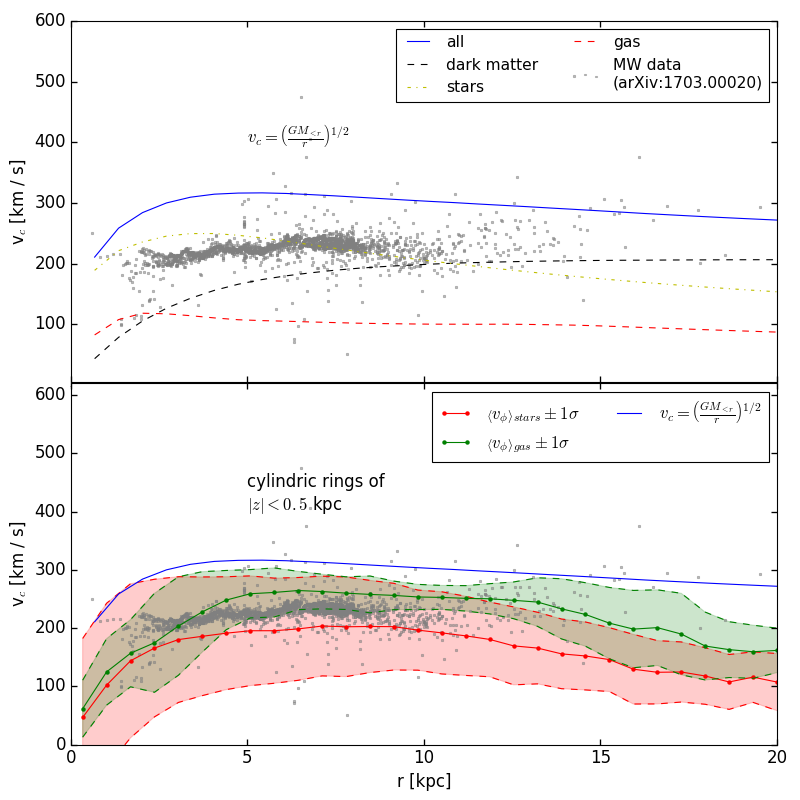

2590 2590


In [53]:
fig, [ax,ax1] = plt.subplots(2,1,figsize=[10,10])
ax.set_ylim(5,600)
ax1.set_ylim(0,600)

ax.set_xlim(0,20)
ax1.set_xlim(0,20)


print len(vc_mw),len(vc_err)
ax.scatter(R_mw,vc_mw,color='gray',marker='s',alpha=0.5,s=2,label="MW data\n(arXiv:1703.00020)")
ax.plot(r, vc_all,'b-',label='all')
ax.plot(r, vc_dm, 'k--',label='dark matter')
ax.plot(r, vc_st, 'y-.',label='stars')
ax.plot(r, vc_gs ,'r--',label='gas')
texto  = r"$v_c = \left(\frac{G M_{<r}}{r}\right)^{1/2}$"
ax.text(5,400,texto,fontsize=15)
#ax.set_xlabel("r [kpc]",fontsize=15)
ax.set_ylabel(r"v$_{c}$ [km / s]",fontsize=15)
legend = ax.legend(loc='upper right', ncol=2, shadow=False, fontsize=14)
frame = legend.get_frame()
ax1.set_ylim(0,620)
ax1.plot(r_arrays,np.abs(vc_stars_vphi)+std_stars_vphi,'r--')
ax1.plot(r_arrays,np.abs(vc_stars_vphi)-std_stars_vphi,'r--')
ax1.fill_between(r_arrays,np.abs(vc_stars_vphi)+std_stars_vphi, np.abs(vc_stars_vphi)-std_stars_vphi,color='r',alpha=0.2)
ax1.plot(r_arrays,np.abs(vc_stars_vphi),'ro-',markersize=4,markeredgewidth=0,
         label=r"$\left<v_{\phi}\right>_{stars} \pm 1 \sigma$ ")
ax1.plot(r_arrays,-vc_gas_vphi-std_gas_vphi,'g--')
ax1.plot(r_arrays,-vc_gas_vphi+std_gas_vphi,'g--')
ax1.fill_between(r_arrays,-vc_gas_vphi+std_gas_vphi, -vc_gas_vphi-std_gas_vphi,color='g',alpha=0.2)
texto_dos = "cylindric rings of\n"
texto_dos += r"$|z| <  0.5$ kpc"
ax1.text(5,400,texto_dos,fontsize=15)
ax1.scatter(R_mw,vc_mw,color='gray',marker='s',alpha=0.5,s=2)

ax1.plot(r_arrays,-vc_gas_vphi,'go-',markersize=4,markeredgewidth=0,label=r"$\left<v_{\phi}\right>_{gas}\pm 1 \sigma$")

ax1.plot(r,vc_all,'b-',label=r"$v_c = \left(\frac{G M_{<r}}{r}\right)^{1/2}$")

ax1.set_xlabel("r [kpc]",fontsize=15)
ax1.set_ylabel(r"v$_{c}$ [km / s]",fontsize=15)
legend = ax1.legend(loc='upper right', ncol=2, shadow=False, fontsize=15)
frame = legend.get_frame()
fig.tight_layout(h_pad=-1.2)
#plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/report07-17/HaloB/circularSpeedsCilyndric.pdf")
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax.tick_params(axis='x', which='minor', labelsize=0, size=3,width=1.2)
ax.tick_params(axis='x', which='major', labelsize=0, size=5,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax1.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)

In [ ]:
# total stellar mass inside 0.1*r97
Mstar = np.sum(myhalo.st.mass[myhalo.st.r < (myhalo.r97/10.)])
# wheighted histogram of mass as the radius grows
hist = np.histogram(myhalo.st.r[myhalo.st.r < (myhalo.r97/10.)],bins=5012,
             weights=myhalo.st.mass[myhalo.st.r < (myhalo.r97/10.)])
# find radius wher 80% of the stellar mass is contained
"""
note that this radius is decided like that by mollitor because
in his sim the rotatioon curve are already flat, in our case this does
not happens..
"""
r_80 = hist[1][np.argmin(np.abs((np.cumsum(hist[0])/hist[0].sum())-0.8))]
# circular speed
v_rot = circular_speed(r_80)

In [ ]:
Sf1_x, Sf1_y =11.0904, 2.5110828926
fig, ax = plt.subplots()
ax.set_xlim(9,12)
ax.set_ylim(1.6,2.6)
ax.set_xlabel(r"Log$_{10}$(M$_{stars}$/M$_{\odot}$)",fontsize=18)
ax.set_ylabel(r"Log$_{10}$(v/(km/s))",fontsize=18)
x = np.arange(9.,14,0.2)
ax.plot(x, 2.179+(x-10.3)*0.259,"k--",label="Dutton et al (2001)")
ax.scatter(np.log10(Mstar),np.log10(v_rot),label="Mochima SF0")
ax.scatter(Sf1_x,Sf1_y,color='r',marker='s',label="Mochima SF1")

ax.scatter(11.25,2.55,color="m",marker="^",edgecolor="k",label="Halo A (Mollitor)aprox")
ax.scatter(10.95,2.4,color="y",marker="^",edgecolor="k",label="Halo C (Mollitor)aprox")
ax.scatter(10.87,2.38,color="c",marker="^",edgecolor="k",label="Halo B (Mollitor)aprox")
legend = ax.legend(loc='lower right', ncol=1, shadow=False, fontsize=15)
frame = legend.get_frame()



In [ ]:
age_hist = np.histogram(myhalo.st.age,bins=256,weights=myhalo.st.mass)
fig,ax = plt.subplots()
ax.set_ylim([0,35])
ax.set_ylabel("SFR [Msun/year]", fontsize=18)
ax.set_xlabel("lookback time [Gyr]", fontsize=18)
thikness=age_hist[1][1]-age_hist[1][0]

ax.plot(-1*age_hist[1][:-1],age_hist[0]/(thikness*1e9))


In [ ]:
print myhalo.dm.total_m

In [ ]:

SF130_faceon, edges = face_on_dm(myhalo,[-1.2*myhalo.r200,1.2*myhalo.r200],300)
length = 15. 
fig,ax = plt.subplots(figsize=[6,6])
fig.tight_layout(w_pad=3)

#######################################################################################################################3
mass_1 = ax.imshow(SF130_faceon+1e3, interpolation='nearest', origin='low',cmap="magma",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e7)
                  )
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')

ax.add_artist(Circle(xy=(0, 0),radius=myhalo.r200,color='w',ls='--',lw=1.7,fill=False))
ax.text(-100,1.1*myhalo.r200,r"R$_{200}$ = 230 Kpc ",color='w',fontsize=15)

In [ ]:
pos_dm = np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(myhalo.gs.pos3d.reshape(len(myhalo.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st, pos_gs))
mass = np.concatenate((myhalo.dm.mass,myhalo.st.mass,myhalo.gs.mass))
v = np.concatenate((myhalo.dm.v,myhalo.st.v,myhalo.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

In [ ]:
ok, acc, Phy = CF.getGravity(pos,mass,0.15,G=myhalo.p.G)
Phy = Phy * myhalo.p.kpctokm**2

In [ ]:
def eddingtong_from_file(path):
    files = np.loadtxt(path)
    return files[:,0], files[:,1]

path = "../../../datafiles/f_Eddington_Mochima2_mass_model_Rmax=1135.0kpc_8.0kpc_velocity_no_divergence.txt"

eddingtong_from_file(path)

In [ ]:
pot_max=-70000
def vesc_from_pot(limmin, limmax):
    """
    a function calculating the vesc from potential inside interval
    """
    contidion = (r2>limmin**2)&(r2<limmax**2)
    mean = np.average(Phy[contidion])
    sigma = np.std((Phy[contidion]))
    v_esc = np.sqrt(2*np.abs(mean - pot_max))
    sig_vesc = sigma / v_esc 
    return v_esc, sig_vesc 


def maxw(v,sigma):
    N = np.sqrt(32 * np.pi) * v**2 / sigma**3
    return N * np.exp(- v**2 / 2. / sigma**2)

get_maxw = np.vectorize(maxw)

def eddingtong_from_file(path):
    files = np.loadtxt(path)
    return files[:,0], files[:,1]

def fdv_plot_chi2_max_edd(ax, path, limmin, limmax,save=False,outname="/home/arturo/Pictures/ploto.png",width=None):
    # get eddington fdv from file
    v, fv = eddingtong_from_file(path)
    # interpolation of eddington points
    f = interp1d(v,fv)
    # get data points from simulations errors included
    # particles in the shell between limmin and limmax
    shell_wc = (myhalo.dm.r>limmin)&(myhalo.dm.r<limmax)
    if width == None:
        width = limmin /6.
    disc = (np.abs(myhalo.dm.pos3d[:,2])<width)
    local_v_wc = myhalo.dm.v[shell_wc]
    v_disc_in_the_shell = myhalo.dm.v[shell_wc&disc]
    Ntot=len(local_v_wc)
    # speed distribution in the shell
    bins = np.linspace(0,local_v_wc.max(),30)
    hist_wc, bins_wc = np.histogram(myhalo.dm.v[shell_wc],bins=bins,normed=True)
    x = (bins_wc[1:]+bins_wc[:-1])/2
    # considering informations from theory inside the bins
    fv_the = np.array([])
    N = np.array([])
    test = np.array([])
    means = np.array([])
    N_disc = np.array([])
    for i in range(len(bins_wc)-1):
        try:
            fv_the = np.append(fv_the, quad(f,bins_wc[i],bins_wc[i+1])[0] / (bins_wc[i+1] - bins_wc[i]))
            test = np.append(test,(bins_wc[i+1]+ bins_wc[i])/2)
            pop = local_v_wc[(local_v_wc>bins_wc[i])&(local_v_wc<=bins_wc[i+1])]
            disc_in_the_bin = v_disc_in_the_shell[(v_disc_in_the_shell>bins_wc[i])&(v_disc_in_the_shell<=bins_wc[i+1])]
            means, N = np.append(means,np.average(pop)), np.append(N,len(pop))
            N_disc = np.append(N_disc,len(disc_in_the_bin))
        except:
            test = np.append(test,(bins_wc[i+1]+ bins_wc[i])/2)
            fv_the = np.append(fv_the,0.0)
            pop = local_v_wc[(local_v_wc>bins_wc[i])&(local_v_wc<=bins_wc[i+1])]
            disc_in_the_bin = v_disc_in_the_shell[(v_disc_in_the_shell>bins_wc[i])&(v_disc_in_the_shell<=bins_wc[i+1])]
            means, N = np.append(means,np.average(pop)), np.append(N,len(pop))
            N_disc = np.append(N_disc,len(disc_in_the_bin))

    dof = len(test)  
    # normalizations factor for data histogram
    Ntot = np.trapz(N,x=means)
    ## MAXWELLIAN Fdv
    # circular velocity
    enclosed_m = (np.sum(mass[np.where(r2<limmin**2)])+ np.sum(mass[np.where(r2<limmax**2)]))/2.
    vc = np.sqrt(myhalo.p.G * enclosed_m / ((limmin + limmax) /2. )) * myhalo.p.kpctokm
    # for gas
    vc_gas = np.mean(myhalo.gs.vphi[(myhalo.gs.R>limmin)&(myhalo.gs.R<limmax)&(np.abs(myhalo.gs.pos3d[:,2])<2.)])
    std_vc_gas = np.std(myhalo.gs.vphi[(myhalo.gs.R>limmin)&(myhalo.gs.R<limmax)&(np.abs(myhalo.gs.pos3d[:,2])<2.)])
    vc_dm = np.nanmean(myhalo.dm.v[(myhalo.dm.R>limmin)&(myhalo.dm.R<limmax)&(np.abs(myhalo.dm.pos3d[:,2])<2.)])
    #for stars
    vc_stars = np.nanmean(myhalo.st.v[(myhalo.st.R>limmin)&(myhalo.st.R<limmax)&(np.abs(myhalo.st.pos3d[:,2])<2.)])
    print np.nanmean(myhalo.st.v[(myhalo.st.r<limmin)&(myhalo.st.r<limmax)])
    std_vc_stars = np.nanstd(myhalo.st.v[(myhalo.st.r>limmin)&(myhalo.st.r<limmax)])    
    leno = len(myhalo.st.v[(myhalo.st.r<limmin)&(myhalo.st.r<limmax)])
    # this sigma is a parameter in the fdv not an error of any kind
    #sigma_8  = vc_dm / np.sqrt(2.)
    sigma_8  = vc / np.sqrt(2.)
    #sigma_8  = vc_gas / np.sqrt(2.)
    #sigma_8  = vc_stars / np.sqrt(2.)
    print "sigma = {0:0.1f}, vc = {1:.1f} km/s".format(sigma_8,vc)
    maxwellian = get_maxw(test,sigma_8)
    # normalizarion factor
    N0 = np.trapz(maxwellian, x=test)
    maxwellian /= N0
    ## CHI2 s 
    #error in data
    sigma = np.sqrt(N) / Ntot
    sigma_disc = np.sqrt(N_disc) / Ntot
    # eddington
    chi2 = np.sum(((N/Ntot) - fv_the)**2 / sigma**2)
    # maxwellian
    chi2_max = np.sum(((N/Ntot) - maxwellian)**2 / sigma**2)
    # v escape from potential
    v_esc , sig_vesc = vesc_from_pot(limmin,limmax)
    # plotting
    ax.set_xlim([0,1.2*v_esc])
    ax.set_ylim([0,1.3*fv_the.max()])
    x=np.linspace(v[0],v[-2],100)
    ax.plot(x,f(x),'k-',lw=1.6,label="eddington")#,yerr=means/np.sqrt(N),xerr=sigma_x)
    ax.errorbar(test,N/Ntot,yerr=np.sqrt(N)/Ntot,xerr=((bins[1:]-bins[:-1])/2.)[:dof],c='g',lw=1.5, label="data")
    #ax.errorbar(test,N_disc/Ntot,yerr=np.sqrt(N_disc)/Ntot,xerr=((bins[1:]-bins[:-1])/2.)[:dof],c='gray',
    #            lw=1.2, ls='None', label=r"in disc of $\Delta$z "+"= {0} kpc".format(2*width))
    ax.set_xlabel(r"$\vec{v}$ [km/s]",fontsize=16)
    ax.set_ylabel(r"$f(v)_{normalized} $ ",fontsize=18)
    ax.axvline(x=v_esc,color='k',linestyle='--')
    ax.axvspan(v_esc-sig_vesc, v_esc+sig_vesc, alpha=0.5, color='red',label=r"$v_{esc} \pm 1\sigma$ ")
    texto_max = "Maxwellian\n"
    texto_max += r"$\chi_{red}^2 = $"
    texto_max += "{0:.2f}".format(chi2_max/dof)
    texto_edd = "Eddington\n"
    texto_edd += r"$\chi_{red}^2 = $"
    texto_edd += "{0:.2f}".format(chi2/dof)
    texto_vc = r"$v_c ^{stars} =$ "
    texto_vc += "{0:.2f}".format(vc_stars,leno)
    texto_vc += "\n"
    texto_vc += "dof = {0}".format(dof)
    
    fig.text(0.15,0.79,texto_max,fontsize=16,color='r')
    fig.text(0.15,0.71,texto_edd,fontsize=16,color='k')
    fig.text(0.15,0.60,texto_vc,fontsize=16,color='k')

    ax.set_title(str(limmin)+" kpc < r < "+str(limmax)+" kpc ", fontsize=18)
    max_v = np.linspace(0,1.5*test.max(),50)
    ax.plot(max_v,get_maxw(max_v,sigma_8)/N0,'r-',lw=1.6,label="maxwellian")
    legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
    frame = legend.get_frame()
    if (save):
        plt.savefig(outname+".pdf",dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=[10,10])
path = "../../../datafiles/f_Eddington_Mochima2_mass_model_Rmax=1135.0kpc_8.0kpc_velocity_no_divergence.txt"
fdv_plot_chi2_max_edd(ax,path,7,9)

In [ ]:
np.mean(myhalo.st.vR[(myhalo.st.r>7)&(myhalo.st.r<9)])